In [311]:
import pandas as pd
import random
import math
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_val_score
from scipy.stats import randint, uniform
from sklearn.utils.class_weight import compute_class_weight

In [312]:
pd.set_option('display.max_columns', 40)

In [313]:
def seed_everything(seed):
    random.seed(seed) #파이썬 자체 모듈 random 모듈의 시드 고정
    os.environ['PYTHONHASHSEED'] = str(seed) 
    np.random.seed(seed)
    
seed_everything(37)

In [314]:
# 한글 폰트 설정
import matplotlib.pyplot as plt
import platform

path = "c:/Windows/Fonts/malgun.ttf"
from matplotlib import font_manager, rc

if platform.system() == 'Darwin':
    plt.rcParams["font.family"] = 'AppleGothic'

elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    plt.rcParams["font.family"] = font_name
elif platform.system() == 'Linux':
    plt.rcParams['font.family'] = 'NanumGothic'


plt.rcParams['axes.unicode_minus'] = False

In [315]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

# Data Preprocessing

## 결측치 개수 변수 생성

In [316]:
ttrain3 = train.copy()

In [317]:
ttrain4 = ttrain3.copy()
ttrain4 = ttrain4.drop(columns = ['허위매물여부'], axis = 1)
# 결측 여부를 이진 변수로 변환
for col in ttrain4.columns:
    ttrain4[f'{col}'] = ttrain4[col].isna().astype(int)
ttrain4    

,ID,매물확인방식,보증금,월세,전용면적,해당층,총층,방향,방수,욕실수,주차가능여부,총주차대수,관리비,중개사무소,제공플랫폼,게재일
0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2447,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2448,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
2449,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2450,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [318]:
ttrain4['결측치개수'] = ttrain4.sum(axis = 1)

In [319]:
ttrain4.결측치개수.unique()

array([2, 0, 1, 6, 3, 5])

In [320]:
ttrain3['결측치개수'] = ttrain4['결측치개수']

In [321]:
ttest = test.copy()
# 결측 여부를 이진 변수로 변환
for col in ttest.columns:
    ttest[f'{col}'] = ttest[col].isna().astype(int)
    
ttest['결측치개수'] = ttest.sum(axis = 1)

In [322]:
ttest.결측치개수.unique()

array([2, 0, 1, 3, 6, 5])

In [323]:
test['결측치개수'] = ttest['결측치개수']

In [324]:
ttrain3 = ttrain3.dropna(subset = ['전용면적', '월세', '보증금'], how = 'any')

In [325]:
train = train.dropna(subset = ['전용면적', '월세', '보증금'], how = 'any')

In [326]:
numeric_cols = [col for col in ttrain3.select_dtypes(include=['number']).columns if col != '허위매물여부']
#train_medians = ttrain3[numeric_cols].median()

In [327]:
numeric_cols

['보증금', '월세', '전용면적', '해당층', '총층', '방수', '욕실수', '총주차대수', '관리비', '결측치개수']

## KNN 보간

In [328]:
train.isnull().sum()

ID          0
매물확인방식      0
보증금         0
월세          0
전용면적        0
해당층       156
총층          0
방향          0
방수          0
욕실수         1
주차가능여부      0
총주차대수     264
관리비         0
중개사무소       0
제공플랫폼       0
게재일         0
허위매물여부      0
dtype: int64

전용면적은 보간하지 않고 test데이터의 결측치는 train 데이터의 분포로 보간.

In [329]:
# 전용면적 최적의 k값
ttrain5 = train.copy()
ttrain5 = ttrain5[['전용면적', '방수', '총주차대수']] #상관관계 히트맵 확인 후 진행
ttrain5

,전용면적,방수,총주차대수
3,36.30,2.0,13.0
5,29.50,2.0,1.0
8,31.55,2.0,18.0
9,39.66,2.0,2.0
10,23.69,1.0,15.0
...,...,...,...
2446,17.50,1.0,104.0
2447,48.95,2.0,NaN
2449,17.50,1.0,29.0
2450,22.87,2.0,NaN


최적의 n_neighbors 값: 5


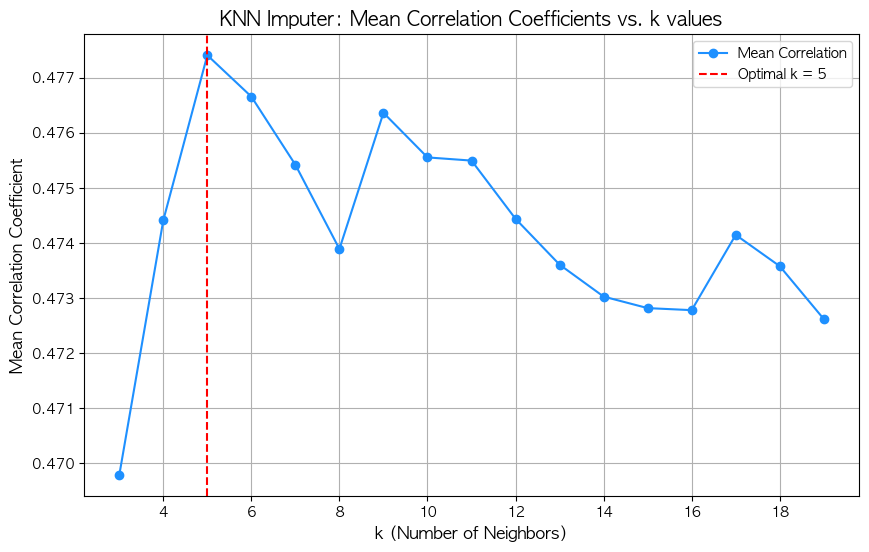

In [330]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer

k_values = list(range(3, 20))

# 상관계수 저장할 딕셔너리
correlation_results = {}

for k in k_values:
    imputer = KNNImputer(n_neighbors=k)
    ttrain5_imputed = pd.DataFrame(imputer.fit_transform(ttrain5), columns=ttrain5.columns)

    # Pearson 상관계수 계산
    corr_matrix = ttrain5_imputed.corr(method='pearson')
    mean_corr = corr_matrix.abs().mean().mean()  # 절대값 평균 상관계수 저장
    correlation_results[k] = mean_corr

# 최적 k 찾기
optimal_k = max(correlation_results, key=correlation_results.get)
print(f"최적의 n_neighbors 값: {optimal_k}")

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(correlation_results.keys(), correlation_results.values(), marker='o', linestyle='-', color='dodgerblue', label="Mean Correlation")
plt.axvline(x=optimal_k, color='red', linestyle='--', label=f"Optimal k = {optimal_k}")
plt.title("KNN Imputer: Mean Correlation Coefficients vs. k values", fontsize=14)
plt.xlabel("k (Number of Neighbors)", fontsize=12)
plt.ylabel("Mean Correlation Coefficient", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

In [331]:
from sklearn.impute import KNNImputer

netLeasableArea_imputer = KNNImputer(n_neighbors=9) #7이 가장 높긴 하지만 9부터 안정적 구간
netLeasableArea_imputer.fit(ttrain5)

KNNImputer(n_neighbors=9)

In [332]:
ttest = test.copy()
ttest = ttest[['전용면적', '방수', '총주차대수']]
ttest_imputed = netLeasableArea_imputer.transform(ttest)
ttest = pd.DataFrame(ttest_imputed)
ttest.columns = ['전용면적', '방수', '총주차대수']
test['전용면적'] = ttest['전용면적']

### 해당층 & 총층

최적의 n_neighbors 값: 13


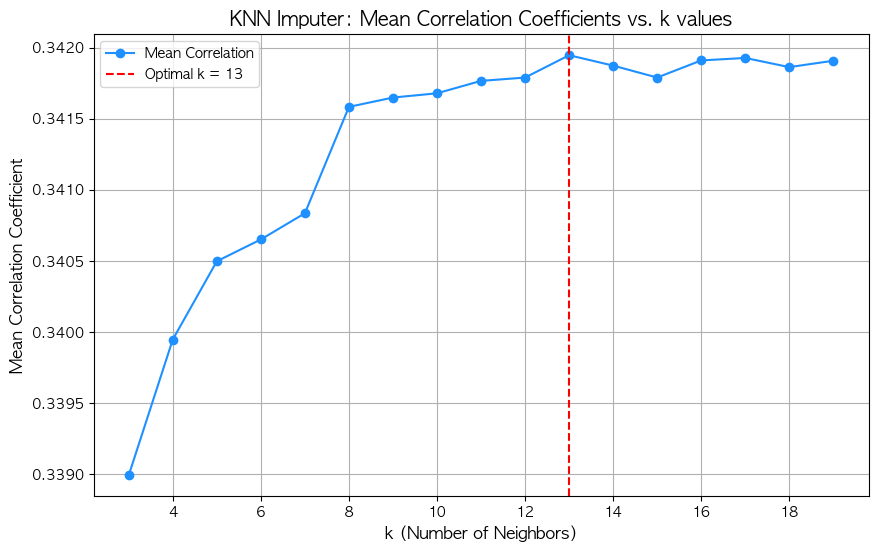

In [333]:
# 해당층 최적의 k값
ttrain5 = train.copy()
ttrain5 = ttrain5[['보증금', '월세', '해당층', '총층']]

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer

k_values = list(range(3, 20))

# 상관계수 저장할 딕셔너리
correlation_results = {}

for k in k_values:
    imputer = KNNImputer(n_neighbors=k)
    ttrain5_imputed = pd.DataFrame(imputer.fit_transform(ttrain5), columns=ttrain5.columns)

    # Pearson 상관계수 계산
    corr_matrix = ttrain5_imputed.corr(method='pearson')
    mean_corr = corr_matrix.abs().mean().mean()  # 절대값 평균 상관계수 저장
    correlation_results[k] = mean_corr

# 최적 k 찾기
optimal_k = max(correlation_results, key=correlation_results.get)
print(f"최적의 n_neighbors 값: {optimal_k}")

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(correlation_results.keys(), correlation_results.values(), marker='o', linestyle='-', color='dodgerblue', label="Mean Correlation")
plt.axvline(x=optimal_k, color='red', linestyle='--', label=f"Optimal k = {optimal_k}")
plt.title("KNN Imputer: Mean Correlation Coefficients vs. k values", fontsize=14)
plt.xlabel("k (Number of Neighbors)", fontsize=12)
plt.ylabel("Mean Correlation Coefficient", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

In [334]:
from sklearn.impute import KNNImputer

print(ttrain5.shape)
t5_index = ttrain5.index

floor_imputer = KNNImputer(n_neighbors=13)
ttrain5_imputed = floor_imputer.fit_transform(ttrain5)

ttrain5 = pd.DataFrame(ttrain5_imputed, index=t5_index)
ttrain5.columns = ['보증금', '월세', '해당층', '총층']
ttrain5.index = t5_index
print(ttrain5.shape)
ttrain5

(1665, 4)
(1665, 4)


,보증금,월세,해당층,총층
3,163500000.0,30000.0,3.000000,9.0
5,153000000.0,530000.0,4.076923,3.0
8,120500000.0,440000.0,1.000000,2.0
9,79500000.0,260000.0,2.000000,3.0
10,187500000.0,390000.0,1.000000,15.0
...,...,...,...,...
2446,365500000.0,190000.0,7.461538,14.0
2447,159000000.0,550000.0,3.000000,3.0
2449,329000000.0,610000.0,8.000000,20.0
2450,31000000.0,400000.0,8.000000,9.0


In [335]:
ttrain3['해당층'] = ttrain5['해당층']
ttrain3['총층'] = ttrain5['총층']

In [336]:
# 테스트 데이터에 적용
ttest = test.copy()
ttest = ttest[['보증금', '월세', '해당층', '총층']]
ttest_imputed = floor_imputer.transform(ttest)
ttest = pd.DataFrame(ttest_imputed)
ttest.columns = ['보증금', '월세', '해당층', '총층']
test['해당층'] = ttest['해당층']
test['총층'] = ttest['총층']

### 총주차대수

최적의 n_neighbors 값: 8


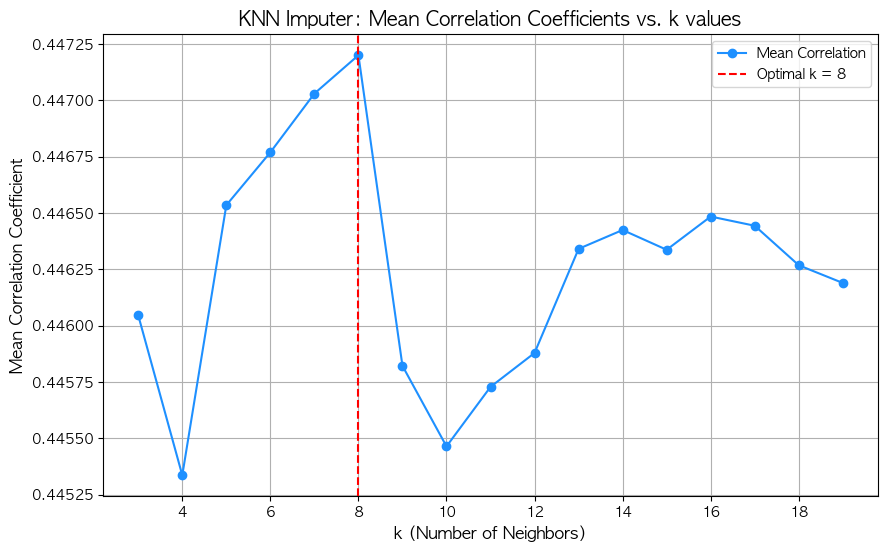

In [337]:
# 총 주차대수 최적의 k값
ttrain5 = train.copy() #보간된 값에 영향받지 않도록 원본 데이터 copy
ttrain5 = ttrain5[['총층', '총주차대수', '전용면적', '해당층']]

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer

k_values = list(range(3, 20))

# 상관계수 저장할 딕셔너리
correlation_results = {}

for k in k_values:
    imputer = KNNImputer(n_neighbors=k)
    ttrain5_imputed = pd.DataFrame(imputer.fit_transform(ttrain5), columns=ttrain5.columns)

    # Pearson 상관계수 계산
    corr_matrix = ttrain5_imputed.corr(method='pearson')
    mean_corr = corr_matrix.abs().mean().mean()  # 절대값 평균 상관계수 저장
    correlation_results[k] = mean_corr

# 최적 k 찾기
optimal_k = max(correlation_results, key=correlation_results.get)
print(f"최적의 n_neighbors 값: {optimal_k}")

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(correlation_results.keys(), correlation_results.values(), marker='o', linestyle='-', color='dodgerblue', label="Mean Correlation")
plt.axvline(x=optimal_k, color='red', linestyle='--', label=f"Optimal k = {optimal_k}")
plt.title("KNN Imputer: Mean Correlation Coefficients vs. k values", fontsize=14)
plt.xlabel("k (Number of Neighbors)", fontsize=12)
plt.ylabel("Mean Correlation Coefficient", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

In [338]:
from sklearn.impute import KNNImputer

print(ttrain5.shape)
t5_index = ttrain5.index

parkingNum_imputer = KNNImputer(n_neighbors=8)
ttrain5_imputed = parkingNum_imputer.fit_transform(ttrain5)

ttrain5 = pd.DataFrame(ttrain5_imputed, index=t5_index)
ttrain5.columns = ['총층', '총주차대수', '전용면적', '해당층']
ttrain5.index = t5_index
print(ttrain5.shape)
ttrain5

(1665, 4)
(1665, 4)


,총층,총주차대수,전용면적,해당층
3,9.0,13.000,36.30,3.0
5,3.0,1.000,29.50,2.0
8,2.0,18.000,31.55,1.0
9,3.0,2.000,39.66,2.0
10,15.0,15.000,23.69,1.0
...,...,...,...,...
2446,14.0,104.000,17.50,10.0
2447,3.0,3.125,48.95,3.0
2449,20.0,29.000,17.50,8.0
2450,9.0,15.625,22.87,8.0


In [339]:
ttrain3['총주차대수'] = ttrain5['총주차대수']

In [340]:
ttest = test.copy()
ttest = ttest[['총층', '총주차대수', '전용면적', '해당층']]
ttest_imputed = parkingNum_imputer.transform(ttest)
ttest = pd.DataFrame(ttest_imputed)
ttest.columns = ['총층', '총주차대수', '전용면적', '해당층']
test['총주차대수'] = ttest['총주차대수']

### 욕실수 & 방수

최적의 n_neighbors 값: 3


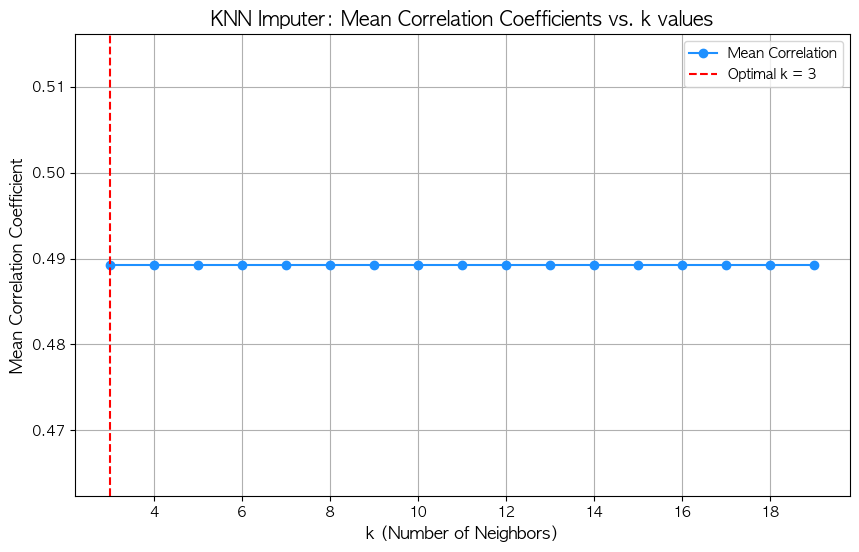

In [341]:
# 욕실수 방수 최적의 k값
ttrain5 = train.copy()
ttrain5 = ttrain5[['욕실수', '전용면적', '방수']]

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer

k_values = list(range(3, 20))

# 상관계수 저장할 딕셔너리
correlation_results = {}

for k in k_values:
    imputer = KNNImputer(n_neighbors=k)
    ttrain5_imputed = pd.DataFrame(imputer.fit_transform(ttrain5), columns=ttrain5.columns)

    # Pearson 상관계수 계산
    corr_matrix = ttrain5_imputed.corr(method='pearson')
    mean_corr = corr_matrix.abs().mean().mean()  # 절대값 평균 상관계수 저장
    correlation_results[k] = mean_corr

# 최적 k 찾기
optimal_k = max(correlation_results, key=correlation_results.get)
print(f"최적의 n_neighbors 값: {optimal_k}")

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(correlation_results.keys(), correlation_results.values(), marker='o', linestyle='-', color='dodgerblue', label="Mean Correlation")
plt.axvline(x=optimal_k, color='red', linestyle='--', label=f"Optimal k = {optimal_k}")
plt.title("KNN Imputer: Mean Correlation Coefficients vs. k values", fontsize=14)
plt.xlabel("k (Number of Neighbors)", fontsize=12)
plt.ylabel("Mean Correlation Coefficient", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

In [342]:
from sklearn.impute import KNNImputer

print(ttrain5.shape)
t5_index = ttrain5.index

bathroom_imputer = KNNImputer(n_neighbors=10) 
ttrain5_imputed = bathroom_imputer.fit_transform(ttrain5)

ttrain5 = pd.DataFrame(ttrain5_imputed, index=t5_index)
ttrain5.columns = ['욕실수', '전용면적', '방수']
ttrain5.index = t5_index
print(ttrain5.shape)
ttrain5

(1665, 3)
(1665, 3)


,욕실수,전용면적,방수
3,1.0,36.30,2.0
5,1.0,29.50,2.0
8,2.0,31.55,2.0
9,1.0,39.66,2.0
10,1.0,23.69,1.0
...,...,...,...
2446,1.0,17.50,1.0
2447,1.0,48.95,2.0
2449,1.0,17.50,1.0
2450,1.0,22.87,2.0


In [343]:
ttrain3['욕실수'] = ttrain5['욕실수']
ttrain3['방수'] = ttrain5['방수']

In [344]:
ttest = test.copy()
ttest = ttest[['욕실수', '전용면적', '방수']]
ttest_imputed = bathroom_imputer.transform(ttest)
ttest = pd.DataFrame(ttest_imputed)
ttest.columns = ['욕실수', '전용면적', '방수']
test['욕실수'] = ttest['욕실수']
test['방수'] = ttest['방수']

In [345]:
ttrain3.isnull().sum()

ID        0
매물확인방식    0
보증금       0
월세        0
전용면적      0
해당층       0
총층        0
방향        0
방수        0
욕실수       0
주차가능여부    0
총주차대수     0
관리비       0
중개사무소     0
제공플랫폼     0
게재일       0
허위매물여부    0
결측치개수     0
dtype: int64

In [346]:
test.isnull().sum()

ID        0
매물확인방식    0
보증금       0
월세        0
전용면적      0
해당층       0
총층        0
방향        0
방수        0
욕실수       0
주차가능여부    0
총주차대수     0
관리비       0
중개사무소     0
제공플랫폼     0
게재일       0
결측치개수     0
dtype: int64

In [347]:
#ttrain3[numeric_cols] = ttrain3[numeric_cols].fillna(ttrain3[numeric_cols].median())

In [348]:
# 테스트 데이터에 적용
#test[numeric_cols] = test[numeric_cols].fillna(train_medians)

## 계층적 클러스터링

In [349]:
from sklearn.preprocessing import StandardScaler

X_m = ttrain3[['전용면적', '방수', '욕실수']]

scaler = StandardScaler()
X_m_scaled = scaler.fit_transform(X_m)

/var/folders/rc/3jzqjhp56_v2qxb49fkb1x880000gn/T/ipykernel_69781/2866546436.py:6: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distance_matrix, method='ward')


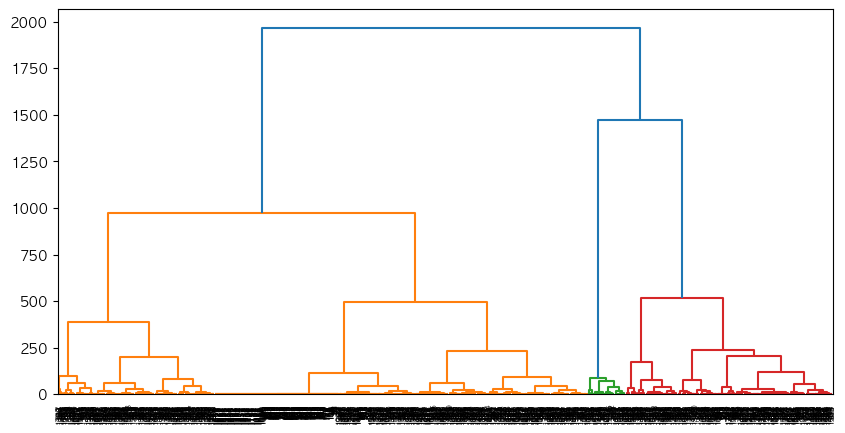

In [350]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist
from sklearn.metrics.pairwise import nan_euclidean_distances

distance_matrix = nan_euclidean_distances(X_m_scaled)
linkage_matrix = linkage(distance_matrix, method='ward')

plt.figure(figsize=(10, 5))
dendrogram(linkage_matrix)
plt.show()

In [351]:
from scipy.cluster.hierarchy import fcluster

# 클러스터 개수를 6개로 설정하여 데이터 분류
labels = fcluster(linkage_matrix, t=6, criterion='maxclust')

print("클러스터 라벨:", labels, "/", len(labels))

클러스터 라벨: [6 6 4 ... 2 6 6] / 1665


In [352]:
# Hierarchical Clustering
property_hierarchical_clustering = pd.Series(labels)
property_hierarchical_clustering.index = ttrain3.index
ttrain3["매물_HC"] = property_hierarchical_clustering
ttrain3["매물_HC"].value_counts()

매물_HC
2    430
3    373
1    337
6    333
5    112
4     80
Name: count, dtype: int64

knn을 이용해 훈련데이터의 클러스터링에 맞게 테스트 데이터에도 수행

In [353]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)  # k=5 (클러스터개수와 상관x)
knn.fit(X_m_scaled, ttrain3['매물_HC'])

# 테스트 데이터 변환 및 예측
X_test = test[['전용면적', '방수', '욕실수']]
X_test_scaled = scaler.transform(X_test)  #train에서 학습한 scaler 사용

In [354]:
test["매물_HC"] = knn.predict(X_test_scaled)
test["매물_HC"].value_counts()

매물_HC
6    193
3    165
2    105
1     98
5     31
4     21
Name: count, dtype: int64

In [355]:
X_test

,전용면적,방수,욕실수
0,26.52,1.0,1.0
1,30.26,1.0,1.0
2,41.50,2.0,1.0
3,31.35,2.0,1.0
4,23.14,1.0,1.0
...,...,...,...
608,30.83,1.0,1.0
609,29.88,2.0,1.0
610,30.73,1.0,1.0
611,17.50,1.0,1.0


In [356]:
# import pickle

# with open("./project/saved/scaler.pkl", "wb") as file:
#     pickle.dump(scaler, file)

# with open("./project/saved/knn_hc.pkl", "wb") as file:
#     pickle.dump(knn, file)

## DBSCAN

In [357]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

# DBSCAN 적용 / 클러스터 6개로 하려면 eps = 0.128
dbscan = DBSCAN(eps=0.1, min_samples=6) #eps : 두 데이터 포인트가 같은 클러스터에 속할 수 있는 최대 거리(밀집 기준)
y_dbscan = dbscan.fit_predict(X_m_scaled)
ttrain3['매물_DBSCAN'] = y_dbscan

In [358]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import pandas as pd

# 노이즈(-1) 데이터 찾기
noise_mask = (y_dbscan == -1)
non_noise_mask = ~noise_mask

# 노이즈가 아닌 데이터로 KNN 학습
knn_dbscan = KNeighborsClassifier(n_neighbors=5)
knn_dbscan.fit(X_m_scaled[non_noise_mask], y_dbscan[non_noise_mask])

# 노이즈 데이터에 대해 KNN으로 클러스터 배정
y_dbscan_filled = y_dbscan.copy()
y_dbscan_filled[noise_mask] = knn_dbscan.predict(X_m_scaled[noise_mask])
ttrain3['매물_DBSCAN'] = y_dbscan_filled
ttrain3['매물_DBSCAN'].value_counts() #노이즈 ID : -1

매물_DBSCAN
2    1129
0     398
4      34
1      33
3      15
5      15
6      13
7      11
8      10
9       7
Name: count, dtype: int64

훈련 데이터에서 노이즈 데이터를 각 클러스터에 배정하기 위해 사용한 knn_dbscan을 가지고 테스트데이터에도 적용

In [359]:
# KNN을 활용하여 테스트 데이터의 클러스터 할당
test['매물_DBSCAN'] = knn_dbscan.predict(X_test_scaled)  # KNN 기반 클러스터 배정
test['매물_DBSCAN'].value_counts()

매물_DBSCAN
2    362
0    216
1     11
8      6
6      6
7      6
4      2
5      2
3      2
Name: count, dtype: int64

In [360]:
# import pickle

# with open("./project/saved/knn_dbscan.pkl", "wb") as file:
#     pickle.dump(knn_dbscan, file)

월세와 보증금 **만단위**로 바꾸기 / **보증금_월세관리비_비율** 변수 **전용면적_가격_비율** 변수 생성

In [361]:
ttrain3["보증금"] = ttrain3["보증금"] / 10000
ttrain3["월세"] = ttrain3["월세"] / 10000
ttrain3['월세+관리비']  = ttrain3['월세'] + ttrain3['관리비']

In [362]:
ttrain3['보증금_월세관리비_비율'] = ttrain3['월세+관리비'] / ttrain3['보증금']
ttrain3['전용면적_가격_비율'] = ttrain3['보증금_월세관리비_비율'] / ttrain3['전용면적']

In [363]:
test["보증금"] = test["보증금"] / 10000
test["월세"] = test["월세"] / 10000
test['월세+관리비']  = test['월세'] + test['관리비']

In [364]:
test['보증금_월세관리비_비율'] = test['월세+관리비'] / test['보증금']
test['전용면적_가격_비율'] = test['보증금_월세관리비_비율'] / test['전용면적']

## KMedoids

In [365]:
from sklearn_extra.cluster import KMedoids
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

# 데이터 스케일링
X_m2 = ttrain3[['매물_HC','매물_DBSCAN', '전용면적_가격_비율', '보증금_월세관리비_비율']]
scaler2 = StandardScaler()
X_m_scaled2 = scaler2.fit_transform(X_m2)

In [366]:
# K-Medoids
kmedoids = KMedoids(n_clusters=11, random_state=42)
ttrain3['지역_KMedoids'] = kmedoids.fit_predict(X_m_scaled2)
ttrain3['지역_KMedoids'].value_counts()

지역_KMedoids
6     459
0     373
3     175
4     116
9     108
1      93
5      83
10     82
2      62
7      61
8      53
Name: count, dtype: int64

In [367]:
from sklearn.neighbors import KNeighborsClassifier

knn_kmedoids = KNeighborsClassifier(n_neighbors=5)  # k=5
knn_kmedoids.fit(X_m_scaled2, ttrain3['지역_KMedoids'])

# 테스트 데이터 변환 및 예측
X_test2 = test[['매물_HC','매물_DBSCAN', '전용면적_가격_비율', '보증금_월세관리비_비율']]
X_test_scaled2 = scaler2.transform(X_test2)  # train에서 학습한 scaler 사용
test["지역_KMedoids"] = knn_kmedoids.predict(X_test_scaled2)  # KNN 기반 클러스터 배정
test['지역_KMedoids'].value_counts()


지역_KMedoids
0     206
6     125
3      57
4      43
5      38
2      37
9      36
7      21
8      18
10     17
1      15
Name: count, dtype: int64

In [368]:
# import pickle

# with open("./project/saved/scaler2.pkl", "wb") as file:
#     pickle.dump(scaler2, file)

# with open("./project/saved/knn_kmedoids.pkl", "wb") as file:
#     pickle.dump(knn_kmedoids, file)

## HDBSCAN

In [369]:
import hdbscan

# HDBSCAN 클러스터링 수행
hdb = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=5, cluster_selection_epsilon = 0.2)
y_hdbscan = hdb.fit_predict(X_m_scaled2)
ttrain3['지역_HDBSCAN'] = y_hdbscan

# 클러스터 개수 확인
ttrain3['지역_HDBSCAN'].value_counts()

지역_HDBSCAN
 10    417
 9     361
 14    282
 12    252
 7      94
-1      82
 2      33
 5      30
 11     17
 13     17
 8      16
 1      15
 6      14
 4      12
 3      12
 0      11
Name: count, dtype: int64

In [370]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import pandas as pd

# 노이즈(-1) 데이터 찾기
noise_mask = (y_hdbscan == -1)
non_noise_mask = ~noise_mask

# 노이즈가 아닌 데이터로 KNN 학습
knn_hdbscan = KNeighborsClassifier(n_neighbors=5)
knn_hdbscan.fit(X_m_scaled2[non_noise_mask], y_hdbscan[non_noise_mask])

# 노이즈 데이터에 대해 KNN으로 클러스터 배정
y_hdbscan_filled = y_hdbscan.copy()
y_hdbscan_filled[noise_mask] = knn_hdbscan.predict(X_m_scaled2[noise_mask])
ttrain3['지역_HDBSCAN'] = y_hdbscan_filled
ttrain3['지역_HDBSCAN'].value_counts() #노이즈 ID : -1

지역_HDBSCAN
10    457
9     365
14    283
12    252
7      95
2      35
8      32
5      31
13     28
11     19
1      16
6      14
4      14
3      13
0      11
Name: count, dtype: int64

In [371]:
from sklearn.neighbors import KNeighborsClassifier

# KNN을 활용하여 테스트 데이터의 클러스터 할당
test['지역_HDBSCAN'] = knn_hdbscan.predict(X_test_scaled2)  # KNN 기반 클러스터 배정

test['지역_HDBSCAN'].value_counts()


지역_HDBSCAN
9     164
12    159
10    107
14     88
7      23
8      20
11     14
5      11
1       6
0       6
3       5
2       3
13      3
4       2
6       2
Name: count, dtype: int64

In [372]:
# with open("./project/saved/knn_hdbscan.pkl", "wb") as file:
#     pickle.dump(knn_hdbscan, file)

## 계절 변수 생성

In [373]:
def get_season(month):
    if month in [3, 4, 5]:
        return '봄'
    elif month in [6, 7, 8]:
        return '여름'
    elif month in [9, 10, 11]:
        return '가을'
    else:
        return '겨울'

ttrain3['게재일'] = pd.to_datetime(ttrain3['게재일'], errors='coerce')
ttrain3['계절'] = ttrain3['게재일'].dt.month.apply(get_season)
ttrain3

,ID,매물확인방식,보증금,월세,전용면적,해당층,총층,방향,방수,욕실수,주차가능여부,총주차대수,관리비,중개사무소,제공플랫폼,게재일,허위매물여부,결측치개수,매물_HC,매물_DBSCAN,월세+관리비,보증금_월세관리비_비율,전용면적_가격_비율,지역_KMedoids,지역_HDBSCAN,계절
3,TRAIN_0003,현장확인,16350.0,3.0,36.30,3.000000,9.0,남동향,2.0,1.0,가능,13.000,10,G52Iz8V2B9,A플랫폼,2024-11-26,0,0,6,0,13.0,0.000795,0.000022,0,12,가을
5,TRAIN_0005,전화확인,15300.0,53.0,29.50,4.076923,3.0,남향,2.0,1.0,가능,1.000,0,Q42YF3Y0I2,A플랫폼,2024-09-12,0,1,6,0,53.0,0.003464,0.000117,0,12,가을
8,TRAIN_0008,현장확인,12050.0,44.0,31.55,1.000000,2.0,북향,2.0,2.0,가능,18.000,3,G52Iz8V2B9,B플랫폼,2024-05-23,0,0,4,1,47.0,0.003900,0.000124,2,5,봄
9,TRAIN_0009,현장확인,7950.0,26.0,39.66,2.000000,3.0,남동향,2.0,1.0,불가능,2.000,0,M90Ph8W9V3,B플랫폼,2024-11-30,0,0,5,0,26.0,0.003270,0.000082,0,7,가을
10,TRAIN_0010,현장확인,18750.0,39.0,23.69,1.000000,15.0,남향,1.0,1.0,불가능,15.000,5,G52Iz8V2B9,A플랫폼,2023-12-16,0,0,3,2,44.0,0.002347,0.000099,4,9,겨울
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2446,TRAIN_2446,전화확인,36550.0,19.0,17.50,7.461538,14.0,남향,1.0,1.0,가능,104.000,10,G38pb6B9C7,C플랫폼,2024-12-10,0,1,2,2,29.0,0.000793,0.000045,6,10,겨울
2447,TRAIN_2447,서류확인,15900.0,55.0,48.95,3.000000,3.0,남향,2.0,1.0,불가능,3.125,0,d22DX4Y4P8,B플랫폼,2024-11-16,0,1,5,6,55.0,0.003459,0.000071,2,3,가을
2449,TRAIN_2449,전화확인,32900.0,61.0,17.50,8.000000,20.0,남서향,1.0,1.0,가능,29.000,10,G52Iz8V2B9,B플랫폼,2024-05-15,0,0,2,2,71.0,0.002158,0.000123,6,10,봄
2450,TRAIN_2450,현장확인,3100.0,40.0,22.87,8.000000,9.0,남동향,2.0,1.0,가능,15.625,8,m69GM9O9B3,B플랫폼,2024-08-06,0,1,6,0,48.0,0.015484,0.000677,0,11,여름


In [374]:
test['게재일'] = pd.to_datetime(test['게재일'], errors='coerce')
test['계절'] = test['게재일'].dt.month.apply(get_season)
test

,ID,매물확인방식,보증금,월세,전용면적,해당층,총층,방향,방수,욕실수,주차가능여부,총주차대수,관리비,중개사무소,제공플랫폼,게재일,결측치개수,매물_HC,매물_DBSCAN,월세+관리비,보증금_월세관리비_비율,전용면적_가격_비율,지역_KMedoids,지역_HDBSCAN,계절
0,TEST_000,서류확인,22300.0,53.0,26.52,5.0,5.0,남향,1.0,1.0,불가능,16.375,7,Z86Th6S3K5,D플랫폼,2024-10-21,2,3,2,60.0,0.002691,0.000101,4,9,가을
1,TEST_001,서류확인,15050.0,59.0,30.26,7.0,11.0,서향,1.0,1.0,불가능,16.000,11,G52Iz8V2B9,D플랫폼,2023-09-02,0,1,2,70.0,0.004651,0.000154,6,14,가을
2,TEST_002,현장확인,4700.0,20.0,41.50,2.0,3.0,남서향,2.0,1.0,불가능,13.625,0,N45gM0M7R0,B플랫폼,2024-04-03,1,5,0,20.0,0.004255,0.000103,0,7,봄
3,TEST_003,서류확인,13300.0,25.0,31.35,5.0,6.0,남향,2.0,1.0,가능,14.125,5,C41wx1K6U9,B플랫폼,2024-09-19,1,6,0,30.0,0.002256,0.000072,0,12,가을
4,TEST_004,현장확인,10800.0,38.0,23.14,2.0,3.0,남향,1.0,1.0,불가능,8.500,0,Z68ZJ6F6L4,A플랫폼,2024-11-10,1,3,2,38.0,0.003519,0.000152,2,9,가을
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608,TEST_608,현장확인,15250.0,34.0,30.83,4.0,6.0,남동향,1.0,1.0,가능,1.000,2,j90UQ8N6M3,A플랫폼,2024-09-24,0,1,2,36.0,0.002361,0.000077,6,14,가을
609,TEST_609,전화확인,22650.0,75.0,29.88,4.0,10.0,남서향,2.0,1.0,가능,34.000,7,r82ax9M3U3,B플랫폼,2024-09-04,1,6,0,82.0,0.003620,0.000121,0,12,가을
610,TEST_610,현장확인,16950.0,50.0,30.73,5.0,6.0,남향,1.0,1.0,불가능,33.000,6,G52Iz8V2B9,F플랫폼,2024-04-20,0,1,2,56.0,0.003304,0.000108,6,14,봄
611,TEST_611,현장확인,18000.0,34.0,17.50,3.0,6.0,남동향,1.0,1.0,가능,2.000,8,J52gJ2E4T6,C플랫폼,2024-11-17,0,2,2,42.0,0.002333,0.000133,6,10,가을


## 매물 등록 경과일 변수 생성

In [375]:
ttrain3['매물_등록_경과일'] = (ttrain3['게재일'].max() - ttrain3['게재일']).dt.days

In [376]:
ttrain3['게재일'].max()

Timestamp('2025-03-03 00:00:00')

In [377]:
# with open("./project/saved/date_max.pkl", "wb") as f:
#     pickle.dump(ttrain3['게재일'].max(), f)

In [378]:
test['매물_등록_경과일'] = (ttrain3['게재일'].max() - test['게재일']).dt.days

## 매물과 지역 클러스터링 따로 분리

In [379]:
매물_HC = ttrain3.매물_HC
매물_DBSCAN = ttrain3.매물_DBSCAN
지역_KMedoids = ttrain3.지역_KMedoids
지역_HDBSCAN = ttrain3.지역_HDBSCAN

In [380]:
매물_HC_test = test.매물_HC
매물_DBSCAN_test = test.매물_DBSCAN
지역_KMedoids_test = test.지역_KMedoids
지역_HDBSCAN_test = test.지역_HDBSCAN

In [381]:
train_y = ttrain3.허위매물여부

### 범주형 컬럼 원핫 인코딩

In [382]:
ttrain3 = pd.get_dummies(ttrain3, columns=['매물확인방식', '방향', '주차가능여부', '계절'], drop_first=True)

one_hot_columns = [col for col in ttrain3.columns if '매물확인방식' in col or '방향' in col or '주차가능여부' in col or '계절' in col]

ttrain3[one_hot_columns] = ttrain3[one_hot_columns].astype(int)

In [383]:
test = pd.get_dummies(test, columns=['매물확인방식', '방향', '주차가능여부', '계절'], drop_first=True)

one_hot_columns = [col for col in test.columns if '매물확인방식' in col or '방향' in col or '주차가능여부' in col or '계절' in col]

test[one_hot_columns] = test[one_hot_columns].astype(int)

필요 없는 컬럼 제거

In [384]:
ttrain3 = ttrain3.drop(columns = ['ID', '중개사무소', '제공플랫폼', '게재일', '월세+관리비', '보증금_월세관리비_비율',
                '매물_HC', '매물_DBSCAN', '지역_KMedoids', '지역_HDBSCAN', '허위매물여부'], axis = 1)

In [385]:
test = test.drop(columns = ['ID', '중개사무소', '제공플랫폼', '게재일', '월세+관리비', '보증금_월세관리비_비율',
                '매물_HC', '매물_DBSCAN', '지역_KMedoids', '지역_HDBSCAN'], axis = 1)

In [386]:
ttrain3.head()

,보증금,월세,전용면적,해당층,총층,방수,욕실수,총주차대수,관리비,결측치개수,전용면적_가격_비율,매물_등록_경과일,매물확인방식_전화확인,매물확인방식_현장확인,방향_남서향,방향_남향,방향_동향,방향_북동향,방향_북서향,방향_북향,방향_서향,주차가능여부_불가능,계절_겨울,계절_봄,계절_여름
3,16350.0,3.0,36.30,3.000000,9.0,2.0,1.0,13.0,10,0,0.000022,97,0,1,0,0,0,0,0,0,0,0,0,0,0
5,15300.0,53.0,29.50,4.076923,3.0,2.0,1.0,1.0,0,1,0.000117,172,1,0,0,1,0,0,0,0,0,0,0,0,0
8,12050.0,44.0,31.55,1.000000,2.0,2.0,2.0,18.0,3,0,0.000124,284,0,1,0,0,0,0,0,1,0,0,0,1,0
9,7950.0,26.0,39.66,2.000000,3.0,2.0,1.0,2.0,0,0,0.000082,93,0,1,0,0,0,0,0,0,0,1,0,0,0
10,18750.0,39.0,23.69,1.000000,15.0,1.0,1.0,15.0,5,0,0.000099,443,0,1,0,1,0,0,0,0,0,1,1,0,0


In [387]:
test.head()

,보증금,월세,전용면적,해당층,총층,방수,욕실수,총주차대수,관리비,결측치개수,전용면적_가격_비율,매물_등록_경과일,매물확인방식_전화확인,매물확인방식_현장확인,방향_남서향,방향_남향,방향_동향,방향_북동향,방향_북서향,방향_북향,방향_서향,주차가능여부_불가능,계절_겨울,계절_봄,계절_여름
0,22300.0,53.0,26.52,5.0,5.0,1.0,1.0,16.375,7,2,0.000101,133,0,0,0,1,0,0,0,0,0,1,0,0,0
1,15050.0,59.0,30.26,7.0,11.0,1.0,1.0,16.000,11,0,0.000154,548,0,0,0,0,0,0,0,0,1,1,0,0,0
2,4700.0,20.0,41.50,2.0,3.0,2.0,1.0,13.625,0,1,0.000103,334,0,1,1,0,0,0,0,0,0,1,0,1,0
3,13300.0,25.0,31.35,5.0,6.0,2.0,1.0,14.125,5,1,0.000072,165,0,0,0,1,0,0,0,0,0,0,0,0,0
4,10800.0,38.0,23.14,2.0,3.0,1.0,1.0,8.500,0,1,0.000152,113,0,1,0,1,0,0,0,0,0,1,0,0,0


매물 클러스터링과 지역 클러스터링 선택 후 원핫인코딩 수행

### 1. 매물_HC + 지역_KMedoids

In [388]:
train_x = pd.concat([ttrain3, 매물_HC, 지역_KMedoids], axis = 1)

In [389]:
train_x = pd.get_dummies(train_x, columns=['매물_HC', '지역_KMedoids'], drop_first=True)
one_hot_columns = [col for col in train_x.columns if 'HC' in col or 'KMedoids' in col]
train_x[one_hot_columns] = train_x[one_hot_columns].astype(int)
train_x

,보증금,월세,전용면적,해당층,총층,방수,욕실수,총주차대수,관리비,결측치개수,전용면적_가격_비율,매물_등록_경과일,매물확인방식_전화확인,매물확인방식_현장확인,방향_남서향,방향_남향,방향_동향,방향_북동향,방향_북서향,방향_북향,방향_서향,주차가능여부_불가능,계절_겨울,계절_봄,계절_여름,매물_HC_2,매물_HC_3,매물_HC_4,매물_HC_5,매물_HC_6,지역_KMedoids_1,지역_KMedoids_2,지역_KMedoids_3,지역_KMedoids_4,지역_KMedoids_5,지역_KMedoids_6,지역_KMedoids_7,지역_KMedoids_8,지역_KMedoids_9,지역_KMedoids_10
3,16350.0,3.0,36.30,3.000000,9.0,2.0,1.0,13.000,10,0,0.000022,97,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
5,15300.0,53.0,29.50,4.076923,3.0,2.0,1.0,1.000,0,1,0.000117,172,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
8,12050.0,44.0,31.55,1.000000,2.0,2.0,2.0,18.000,3,0,0.000124,284,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
9,7950.0,26.0,39.66,2.000000,3.0,2.0,1.0,2.000,0,0,0.000082,93,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
10,18750.0,39.0,23.69,1.000000,15.0,1.0,1.0,15.000,5,0,0.000099,443,0,1,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2446,36550.0,19.0,17.50,7.461538,14.0,1.0,1.0,104.000,10,1,0.000045,83,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2447,15900.0,55.0,48.95,3.000000,3.0,2.0,1.0,3.125,0,1,0.000071,107,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
2449,32900.0,61.0,17.50,8.000000,20.0,1.0,1.0,29.000,10,0,0.000123,292,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2450,3100.0,40.0,22.87,8.000000,9.0,2.0,1.0,15.625,8,1,0.000677,209,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [390]:
test_x = pd.concat([test, 매물_HC_test, 지역_KMedoids_test], axis = 1)

In [391]:
test_x = pd.get_dummies(test_x, columns=['매물_HC', '지역_KMedoids'], drop_first=True)
one_hot_columns = [col for col in test_x.columns if 'HC' in col or 'KMedoids' in col]
test_x[one_hot_columns] = test_x[one_hot_columns].astype(int)
test_x

,보증금,월세,전용면적,해당층,총층,방수,욕실수,총주차대수,관리비,결측치개수,전용면적_가격_비율,매물_등록_경과일,매물확인방식_전화확인,매물확인방식_현장확인,방향_남서향,방향_남향,방향_동향,방향_북동향,방향_북서향,방향_북향,방향_서향,주차가능여부_불가능,계절_겨울,계절_봄,계절_여름,매물_HC_2,매물_HC_3,매물_HC_4,매물_HC_5,매물_HC_6,지역_KMedoids_1,지역_KMedoids_2,지역_KMedoids_3,지역_KMedoids_4,지역_KMedoids_5,지역_KMedoids_6,지역_KMedoids_7,지역_KMedoids_8,지역_KMedoids_9,지역_KMedoids_10
0,22300.0,53.0,26.52,5.0,5.0,1.0,1.0,16.375,7,2,0.000101,133,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
1,15050.0,59.0,30.26,7.0,11.0,1.0,1.0,16.000,11,0,0.000154,548,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,4700.0,20.0,41.50,2.0,3.0,2.0,1.0,13.625,0,1,0.000103,334,0,1,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,13300.0,25.0,31.35,5.0,6.0,2.0,1.0,14.125,5,1,0.000072,165,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,10800.0,38.0,23.14,2.0,3.0,1.0,1.0,8.500,0,1,0.000152,113,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608,15250.0,34.0,30.83,4.0,6.0,1.0,1.0,1.000,2,0,0.000077,160,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
609,22650.0,75.0,29.88,4.0,10.0,2.0,1.0,34.000,7,1,0.000121,180,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
610,16950.0,50.0,30.73,5.0,6.0,1.0,1.0,33.000,6,0,0.000108,317,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
611,18000.0,34.0,17.50,3.0,6.0,1.0,1.0,2.000,8,0,0.000133,106,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [392]:
test_x.columns

Index(['보증금', '월세', '전용면적', '해당층', '총층', '방수', '욕실수', '총주차대수', '관리비', '결측치개수',
       '전용면적_가격_비율', '매물_등록_경과일', '매물확인방식_전화확인', '매물확인방식_현장확인', '방향_남서향',
       '방향_남향', '방향_동향', '방향_북동향', '방향_북서향', '방향_북향', '방향_서향', '주차가능여부_불가능',
       '계절_겨울', '계절_봄', '계절_여름', '매물_HC_2', '매물_HC_3', '매물_HC_4', '매물_HC_5',
       '매물_HC_6', '지역_KMedoids_1', '지역_KMedoids_2', '지역_KMedoids_3',
       '지역_KMedoids_4', '지역_KMedoids_5', '지역_KMedoids_6', '지역_KMedoids_7',
       '지역_KMedoids_8', '지역_KMedoids_9', '지역_KMedoids_10'],
      dtype='object')

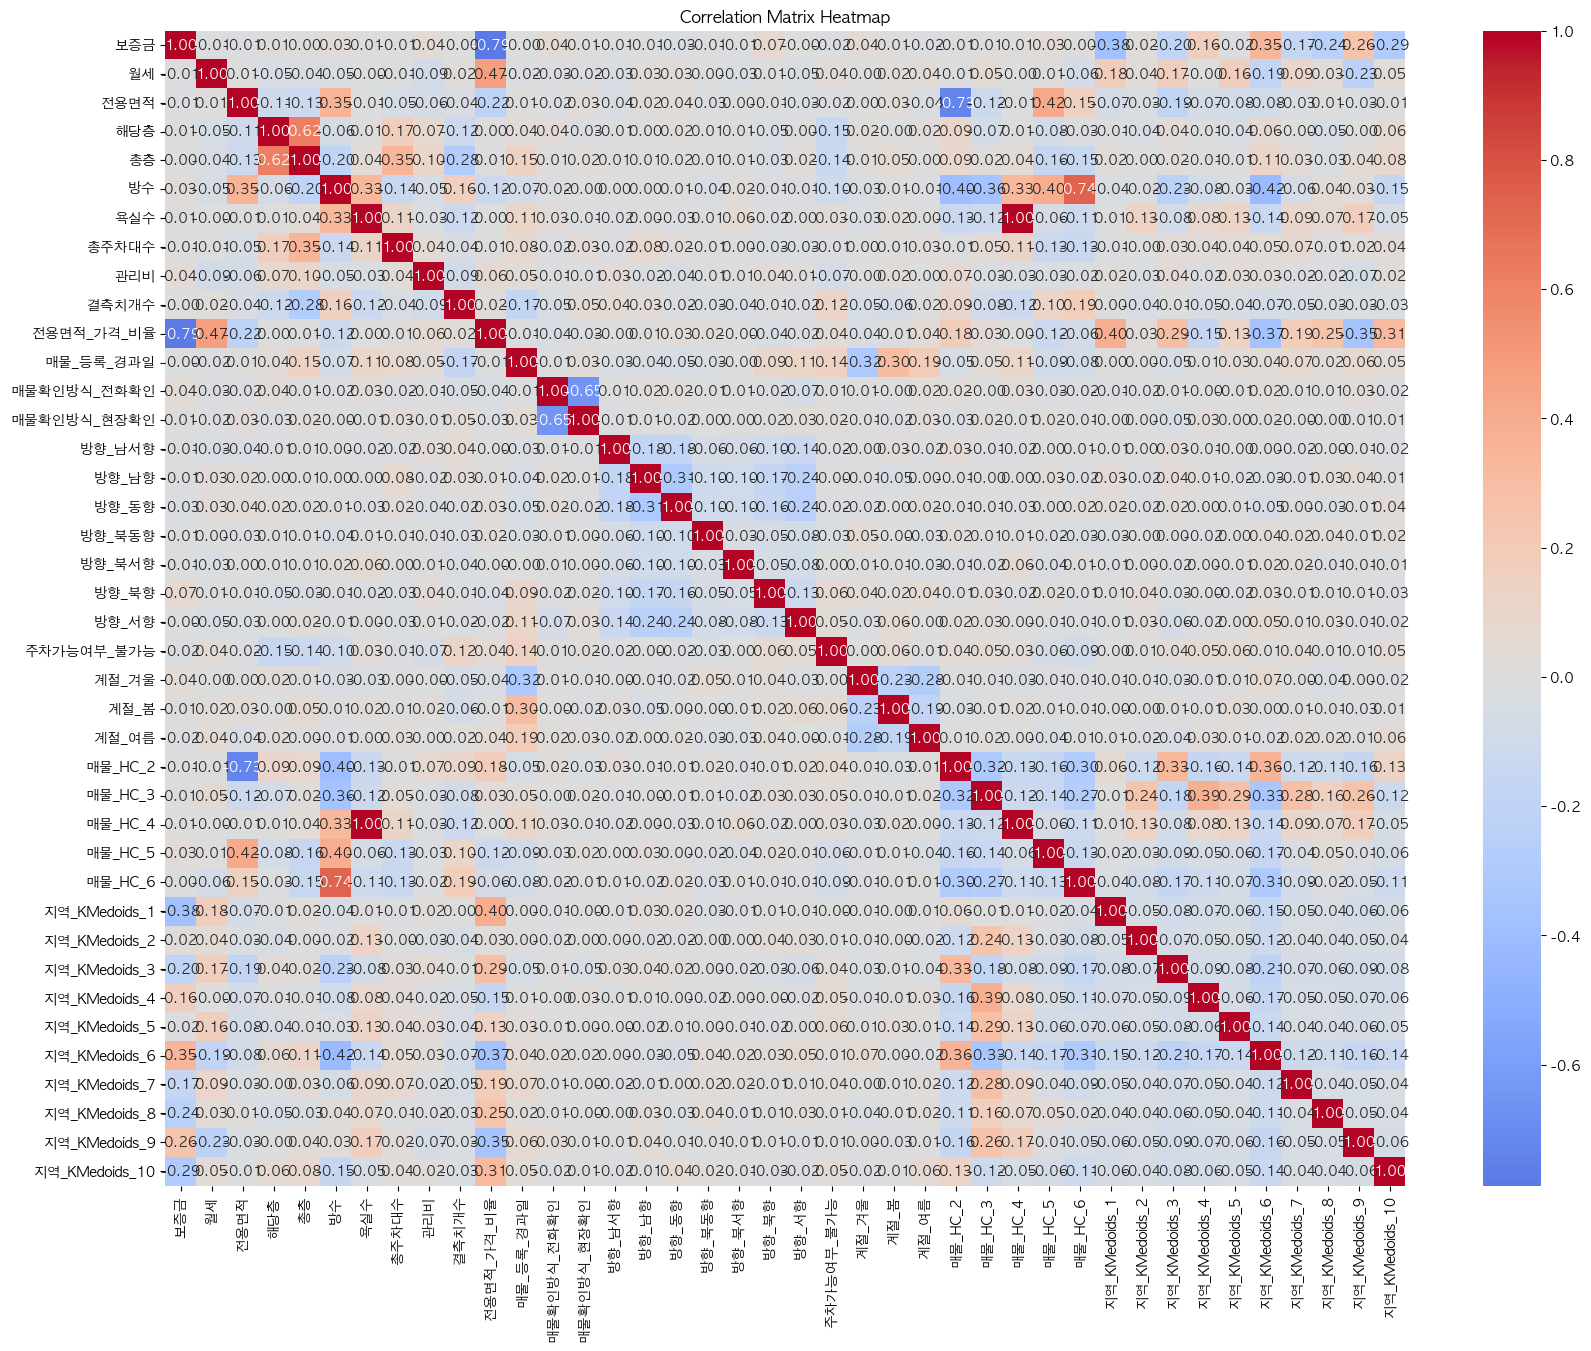

In [ ]:
train_cor_df = train_x.select_dtypes(include=[np.number])
correlation_matrix = train_cor_df.corr(method='spearman')

# 히트맵 생성
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, center = 0)
plt.title("Correlation Matrix Heatmap")
plt.savefig("../image/correlation_matrix_heatmap_spearman__023train_x다중공선성확인_250227.png", dpi=300, bbox_inches='tight')
plt.show()

In [310]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(df):
    """
    데이터프레임의 모든 수치형 독립변수에 대해 VIF(분산팽창계수)를 계산하는 함수
    """
    # 수치형 변수만 선택
    numeric_df = df.select_dtypes(include=['number'])

    # VIF 계산
    vif_data = pd.DataFrame()
    vif_data["Feature"] = numeric_df.columns
    vif_data["VIF"] = [variance_inflation_factor(numeric_df.values, i) for i in range(numeric_df.shape[1])]

    return vif_data


vif_result = calculate_vif(train_x)

# VIF가 높은 컬럼부터 정렬하여 출력
vif_result = vif_result.sort_values(by="VIF", ascending=False)
vif_result

,Feature,VIF
2,전용면적,43.035108
5,방수,31.040134
33,지역_KMedoids_6,8.973492
4,총층,8.542627
25,매물_HC_3,7.984296
1,월세,6.224210
9,전용면적_가격_비율,6.199667
0,보증금,5.750912
12,매물확인방식_현장확인,5.663806
24,매물_HC_2,5.524633


- 다중공선성이 높은 **전용면적**을 제거했습니다. (상관계수가 높은 전용면적_가격_비율로 대신할 수 있음)
- 다중공선성이 높은 **방수**를 제거했습니다. (매물 클러스터링으로 인해 높음)
- 상관계수가 높은 욕실수와 매물_HC_4 중 욕실수를 제거 했으며(아래에서 SHAP 분석을 참고하여) 상관계수가 높은 매물_HC_6과 방수 중 매물_HC_6을 제거했습니다. 

In [393]:
train_x = train_x.drop(columns = ['전용면적', '방수', '욕실수', '매물_HC_6'], axis = 1)
test_x = test_x.drop(columns = ['전용면적', '방수', '욕실수', '매물_HC_6'], axis = 1)

In [119]:
train_x.to_csv('./data/train_x.csv', index = False)
test_x.to_csv('./data/test_x.csv', index = False)

In [ ]:
train_x = pd.read_csv('./data/train_x.csv')
test_x = pd.read_csv('./data/test_x.csv')

2. 매물_HC + 지역_HDBSCAN

In [ ]:
train_x = pd.concat([ttrain3, 매물_HC, 지역_HDBSCAN], axis = 1)

3. 매물_DBSCAN + 지역_KMedoids

In [ ]:
train_x = pd.concat([ttrain3, 매물_DBSCAN, 지역_KMedoids], axis = 1)

4. 매물_DBSCAN + 지역_HDBSCAN

In [ ]:
train_x = pd.concat([ttrain3, 매물_DBSCAN, 지역_HDBSCAN], axis = 1)

# Model Train & Predict

In [412]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
import time
import json
from collections import Counter
from datetime import datetime


# 정확도 및 여러 평가지표를 모델별로 비교하기 위해 test셋을 따로 또 나눔 7-3-3
X_train, X_val, y_train, y_val = train_test_split(
    train_x, train_y, test_size=0.3, stratify=train_y, random_state=37
)

class_counts = Counter(y_train)
scale_pos_weight = class_counts[0] / class_counts[1]


# param_grid = {
#     'learning_rate': [0.04, 0.06, 0.08, 0.1],
#     'subsample': [0.8, 0.85, 0.9],
#     'colsample_bytree': [0.7, 0.8, 0.9],
#     'max_depth': [3, 4, 5, 6],
#     'min_child_weight': [1],
#     'reg_lambda': [3, 4, 5], #[1, 3, 5, 7, 10]
#     'reg_alpha': [2, 3, 4], # [0, 1, 3, 5, 7]
#     'min_split_loss': [0.3, 0.4, 0.5], # gamma 0, 0.1, 0.2, 0.3,
#     'scale_pos_weight' : [scale_pos_weight]
# }


param_grid = {
    'learning_rate': [0.04],
    'subsample': [0.9],
    'colsample_bytree': [0.9],
    'max_depth': [5],
    'min_child_weight': [1],
    'reg_lambda': [1], #[1, 3, 5, 7, 10]
    'reg_alpha': [1], # [0, 1, 3, 5, 7]
    'min_split_loss': [0.4], # gamma 0, 0.1, 0.2, 0.3,
    'scale_pos_weight' : [scale_pos_weight]
}

xgb_model = XGBClassifier(
    random_state=37,
    n_estimators=500,
    eval_metric="logloss",
    objective="binary:logistic",
    use_label_encoder=False,
    early_stopping_rounds=50,
    scale_pos_weight = scale_pos_weight
)

grid_cv = GridSearchCV(
    estimator=xgb_model, 
    param_grid=param_grid, 
    cv=5,               # 5-Fold 교차검증
    scoring='f1_macro',
    n_jobs=-1,          # 모든 CPU 사용
    verbose=3
)

grid_start = time.time()
readable_time = datetime.fromtimestamp(grid_start).strftime('%Y-%m-%d %H:%M:%S')
print(readable_time, "에 시작!")


grid_cv.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)
grid_end = time.time()

final_model = XGBClassifier(
    random_state=37,
    n_estimators=500,
    eval_metric='mlogloss',
    use_label_encoder=False,
    **grid_cv.best_params_
)

final_model.fit(X_train, y_train)

2025-02-27 18:09:43 에 시작!
Fitting 5 folds for each of 1 candidates, totalling 5 fits


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.04, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=1, min_split_loss=0.4,
              missing=nan, monotone_constraints=None, multi_strategy=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None, ...)

In [413]:
readable_time = datetime.fromtimestamp(grid_end).strftime('%Y-%m-%d %H:%M:%S')
print(readable_time, "에 끝!")
print(f'최적 하이퍼파라미터: {grid_cv.best_params_}') # 0.82915
print(f'최고 예측 점수: {grid_cv.best_score_:.4f}') # 다중공선성 제거 grid_Search
print(f'소요 시간: {(grid_end - grid_start)/60:.2f}분') #1 candidates
print(f'표준오차: {grid_cv.cv_results_["std_test_score"][0]}')

2025-02-27 18:09:44 에 끝!
최적 하이퍼파라미터: {'colsample_bytree': 0.9, 'learning_rate': 0.04, 'max_depth': 5, 'min_child_weight': 1, 'min_split_loss': 0.4, 'reg_alpha': 1, 'reg_lambda': 1, 'scale_pos_weight': 9.495495495495495, 'subsample': 0.9}
최고 예측 점수: 0.8449
소요 시간: 0.03분
표준오차: 0.024092942625257432


In [402]:
readable_time = datetime.fromtimestamp(grid_end).strftime('%Y-%m-%d %H:%M:%S')
print(readable_time, "에 끝!")
print(f'최적 하이퍼파라미터: {grid_cv.best_params_}') # 0.82915
print(f'최고 예측 점수: {grid_cv.best_score_:.4f}') # 다중공선성 제거 grid_Search
print(f'소요 시간: {(grid_end - grid_start)/60:.2f}분') #1 candidates
print(f'표준오차: {grid_cv.cv_results_["std_test_score"][0]}')

2025-02-27 18:04:31 에 끝!
최적 하이퍼파라미터: {'colsample_bytree': 0.9, 'learning_rate': 0.04, 'max_depth': 5, 'min_child_weight': 1, 'min_split_loss': 0.4, 'reg_alpha': 1, 'reg_lambda': 2, 'scale_pos_weight': 9.495495495495495, 'subsample': 0.9}
최고 예측 점수: 0.8492
소요 시간: 0.05분
표준오차: 0.0162372895591944


In [395]:
readable_time = datetime.fromtimestamp(grid_end).strftime('%Y-%m-%d %H:%M:%S')
print(readable_time, "에 끝!")
print(f'최적 하이퍼파라미터: {grid_cv.best_params_}') # 0.81429
print(f'최고 예측 점수: {grid_cv.best_score_:.4f}') # 다중공선성 제거 grid_Search
print(f'소요 시간: {(grid_end - grid_start)/60:.2f}분') #3888 candidates
print(f'표준오차: {grid_cv.cv_results_["std_test_score"][0]}')

2025-02-27 17:53:58 에 끝!
최적 하이퍼파라미터: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'min_split_loss': 0.4, 'reg_alpha': 3, 'reg_lambda': 3, 'scale_pos_weight': 9.495495495495495, 'subsample': 0.9}
최고 예측 점수: 0.8615
소요 시간: 29.10분
표준오차: 0.027252091448023694

[CV 3/5] END colsample_bytree=0.9, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=4, scale_pos_weight=9.495495495495495, subsample=0.9;, score=0.823 total time=   0.4s
[CV 5/5] END colsample_bytree=0.9, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=5, scale_pos_weight=9.495495495495495, subsample=0.8;, score=0.840 total time=   0.6s
[CV 4/5] END colsample_bytree=0.9, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=5, scale_pos_weight=9.495495495495495, subsample=0.9;, score=0.884 total time=   0.7s
[CV 1/5] END colsample_bytree=0.9, learning_rate=0.1,


[CV 3/5] END colsample_bytree=0.9, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=2, reg_lambda=3, scale_pos_weight=9.495495495495495, subsample=0.8;, score=0.807 total time=   0.5s
[CV 5/5] END colsample_bytree=0.9, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=2, reg_lambda=3, scale_pos_weight=9.495495495495495, subsample=0.85;, score=0.857 total time=   0.9s
[CV 2/5] END colsample_bytree=0.9, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=2, reg_lambda=4, scale_pos_weight=9.495495495495495, subsample=0.8;, score=0.799 total time=   0.5s
[CV 5/5] END colsample_bytree=0.9, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=2, reg_lambda=4, scale_pos_weight=9.495495495495495, subsample=0.85;, score=0.848 total time=   0.7s
[CV 1/5] END colsample_bytree=0.9, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=2, reg_


[CV 1/5] END colsample_bytree=0.9, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=5, scale_pos_weight=9.495495495495495, subsample=0.85;, score=0.865 total time=   0.9s
[CV 4/5] END colsample_bytree=0.9, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=5, scale_pos_weight=9.495495495495495, subsample=0.9;, score=0.888 total time=   0.9s
[CV 3/5] END colsample_bytree=0.9, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=3, scale_pos_weight=9.495495495495495, subsample=0.85;, score=0.791 total time=   0.6s
[CV 2/5] END colsample_bytree=0.9, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=4, scale_pos_weight=9.495495495495495, subsample=0.8;, score=0.782 total time=   0.7s
[CV 4/5] END colsample_bytree=0.9, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_


[CV 4/5] END colsample_bytree=0.9, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=5, scale_pos_weight=9.495495495495495, subsample=0.8;, score=0.888 total time=   0.6s
[CV 3/5] END colsample_bytree=0.9, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=5, scale_pos_weight=9.495495495495495, subsample=0.9;, score=0.816 total time=   0.4s
[CV 5/5] END colsample_bytree=0.9, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=3, scale_pos_weight=9.495495495495495, subsample=0.8;, score=0.832 total time=   0.6s
[CV 5/5] END colsample_bytree=0.9, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=3, scale_pos_weight=9.495495495495495, subsample=0.9;, score=0.830 total time=   0.4s
[CV 5/5] END colsample_bytree=0.9, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=

In [299]:
readable_time = datetime.fromtimestamp(grid_end).strftime('%Y-%m-%d %H:%M:%S')
print(readable_time, "에 끝!")
print(f'최적 하이퍼파라미터: {grid_cv.best_params_}') #0.83474 
print(f'최고 예측 점수: {grid_cv.best_score_:.4f}') # 전용면적 제외한 모든 결측치 knn보간 _alpha1ambda2
print(f'소요 시간: {(grid_end - grid_start)/60:.2f}분') #1 candidates
print(f'표준오차: {grid_cv.cv_results_["std_test_score"][0]}')

2025-02-27 16:19:31 에 끝!
최적 하이퍼파라미터: {'colsample_bytree': 0.9, 'learning_rate': 0.04, 'max_depth': 5, 'min_child_weight': 1, 'min_split_loss': 0.4, 'reg_alpha': 1, 'reg_lambda': 2, 'scale_pos_weight': 9.495495495495495, 'subsample': 0.9}
최고 예측 점수: 0.8423
소요 시간: 0.05분
표준오차: 0.03551314804966079


In [209]:
readable_time = datetime.fromtimestamp(grid_end).strftime('%Y-%m-%d %H:%M:%S')
print(readable_time, "에 끝!")
print(f'최적 하이퍼파라미터: {grid_cv.best_params_}') #0.82915
print(f'최고 예측 점수: {grid_cv.best_score_:.4f}') # 전용면적 제외한 모든 결측치 knn보간 _alpha1ambda2
print(f'소요 시간: {(grid_end - grid_start)/60:.2f}분') #1 candidates
print(f'표준오차: {grid_cv.cv_results_["std_test_score"][0]}')

2025-02-26 19:12:22 에 끝!
최적 하이퍼파라미터: {'colsample_bytree': 0.9, 'learning_rate': 0.04, 'max_depth': 5, 'min_child_weight': 1, 'min_split_loss': 0.4, 'reg_alpha': 1, 'reg_lambda': 1, 'scale_pos_weight': 9.495495495495495, 'subsample': 0.9}
최고 예측 점수: 0.8395
소요 시간: 0.04분
표준오차: 0.02973113504933661


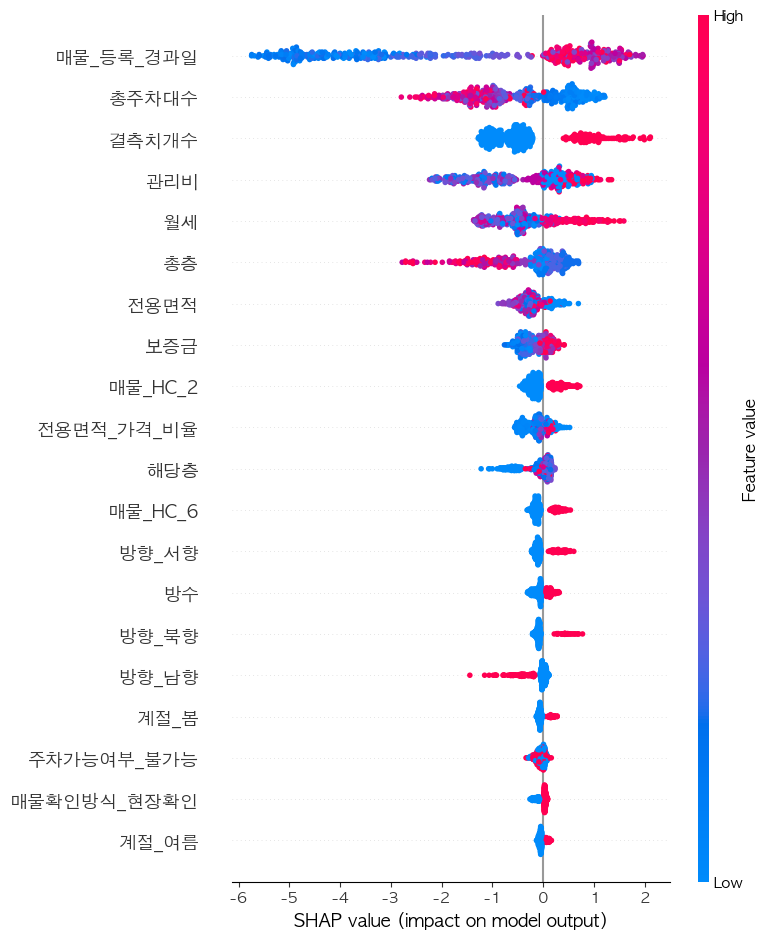

In [300]:
import shap

# SHAP Explainer 생성
explainer = shap.Explainer(final_model)
shap_values = explainer(X_val)

# 전체 Feature 중요도 시각화
shap.summary_plot(shap_values, X_val)


In [302]:
shap_values_df = pd.DataFrame(shap_values.values, columns=X_val.columns)
shap_values_df.abs().mean().sort_values(ascending=False).tail(10)  # 중요도가 낮은 변수 10개 확인
low_shap_features = shap_values_df.abs().mean().sort_values().head(10).index.tolist()
print("SHAP 중요도가 낮은 변수들:", low_shap_features)

SHAP 중요도가 낮은 변수들: ['지역_KMedoids_1', '방향_북동향', '매물_HC_4', '지역_KMedoids_8', '지역_KMedoids_2', '지역_KMedoids_4', '지역_KMedoids_7', '방향_남서향', '지역_KMedoids_9', '욕실수']


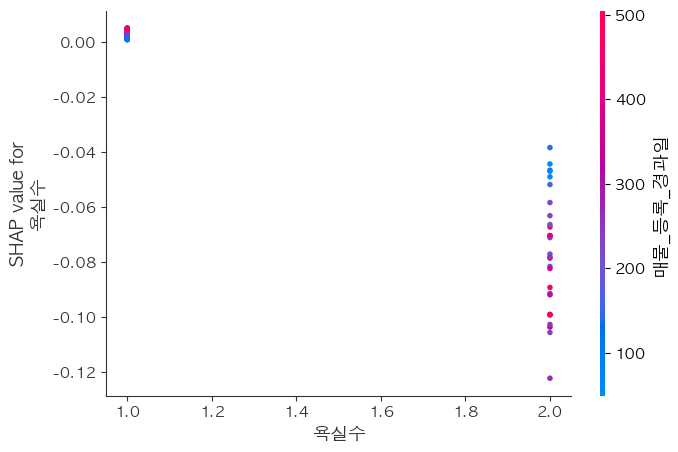

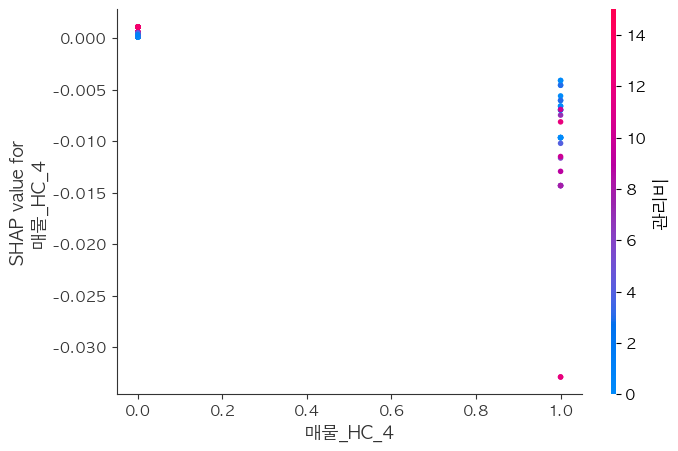

In [304]:
shap.dependence_plot("욕실수", shap_values.values, X_val)
shap.dependence_plot("매물_HC_4", shap_values.values, X_val)


In [202]:
readable_time = datetime.fromtimestamp(grid_end).strftime('%Y-%m-%d %H:%M:%S')
print(readable_time, "에 끝!")
print(f'최적 하이퍼파라미터: {grid_cv.best_params_}') #0.83474 
print(f'최고 예측 점수: {grid_cv.best_score_:.4f}') # 전용면적 제외한 모든 결측치 knn보간 _alpha1ambda2
print(f'소요 시간: {(grid_end - grid_start)/60:.2f}분') #1 candidates
print(f'표준오차: {grid_cv.cv_results_["std_test_score"][0]}')

2025-02-26 19:09:39 에 끝!
최적 하이퍼파라미터: {'colsample_bytree': 0.9, 'learning_rate': 0.04, 'max_depth': 5, 'min_child_weight': 1, 'min_split_loss': 0.4, 'reg_alpha': 1, 'reg_lambda': 2, 'scale_pos_weight': 9.495495495495495, 'subsample': 0.9}
최고 예측 점수: 0.8423
소요 시간: 0.03분
표준오차: 0.03551314804966079


In [195]:
readable_time = datetime.fromtimestamp(grid_end).strftime('%Y-%m-%d %H:%M:%S')
print(readable_time, "에 끝!")
print(f'최적 하이퍼파라미터: {grid_cv.best_params_}') # 0.82368
print(f'최고 예측 점수: {grid_cv.best_score_:.4f}') # 전용면적 제외한 모든 결측치 knn보간 _정규화1씩내림
print(f'소요 시간: {(grid_end - grid_start)/60:.2f}분') #1 candidates
print(f'표준오차: {grid_cv.cv_results_["std_test_score"][0]}')

2025-02-26 19:07:30 에 끝!
최적 하이퍼파라미터: {'colsample_bytree': 0.9, 'learning_rate': 0.04, 'max_depth': 5, 'min_child_weight': 1, 'min_split_loss': 0.4, 'reg_alpha': 2, 'reg_lambda': 2, 'scale_pos_weight': 9.495495495495495, 'subsample': 0.9}
최고 예측 점수: 0.8441
소요 시간: 0.04분
표준오차: 0.04305182708942289


In [188]:
readable_time = datetime.fromtimestamp(grid_end).strftime('%Y-%m-%d %H:%M:%S')
print(readable_time, "에 끝!")
print(f'최적 하이퍼파라미터: {grid_cv.best_params_}') # 0.80285
print(f'최고 예측 점수: {grid_cv.best_score_:.4f}') # 전용면적 제외한 모든 결측치 knn보간 _정규화1씩올림
print(f'소요 시간: {(grid_end - grid_start)/60:.2f}분') #1 candidates
print(f'표준오차: {grid_cv.cv_results_["std_test_score"][0]}')

2025-02-26 19:03:46 에 끝!
최적 하이퍼파라미터: {'colsample_bytree': 0.9, 'learning_rate': 0.04, 'max_depth': 5, 'min_child_weight': 1, 'min_split_loss': 0.4, 'reg_alpha': 4, 'reg_lambda': 4, 'scale_pos_weight': 9.495495495495495, 'subsample': 0.9}
최고 예측 점수: 0.8360
소요 시간: 0.05분
표준오차: 0.043824901375471126


In [180]:
readable_time = datetime.fromtimestamp(grid_end).strftime('%Y-%m-%d %H:%M:%S')
print(readable_time, "에 끝!")
print(f'최적 하이퍼파라미터: {grid_cv.best_params_}') # 0.82915
print(f'최고 예측 점수: {grid_cv.best_score_:.4f}') # 전용면적 제외한 모든 결측치 knn보간
print(f'소요 시간: {(grid_end - grid_start)/60:.2f}분') #3888 candidates
print(f'표준오차: {grid_cv.cv_results_["std_test_score"][0]}')

2025-02-26 18:57:09 에 끝!
최적 하이퍼파라미터: {'colsample_bytree': 0.9, 'learning_rate': 0.04, 'max_depth': 5, 'min_child_weight': 1, 'min_split_loss': 0.4, 'reg_alpha': 3, 'reg_lambda': 3, 'scale_pos_weight': 9.495495495495495, 'subsample': 0.9}
최고 예측 점수: 0.8669
소요 시간: 28.68분
표준오차: 0.02310337964367558


In [61]:
print(f'최적 하이퍼파라미터: {grid_cv.best_params_}') #0.83285
print(f'최고 예측 점수: {grid_cv.best_score_:.4f}') #게재일 max train으 max로 수정
print(f'소요 시간: {grid_end - grid_start:.2f}초') #최고 성능 결과

최적 하이퍼파라미터: {'colsample_bytree': 0.7, 'learning_rate': 0.08, 'max_depth': 6, 'min_child_weight': 1, 'min_split_loss': 0.3, 'reg_alpha': 4, 'reg_lambda': 5, 'scale_pos_weight': 9.495495495495495, 'subsample': 0.85}
최고 예측 점수: 0.8569
소요 시간: 1738.20초

[CV 3/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=5, scale_pos_weight=9.495495495495495, subsample=0.85;, score=0.799 total time=   0.5s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=5, scale_pos_weight=9.495495495495495, subsample=0.9;, score=0.933 total time=   0.8s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.5, reg_alpha=1, reg_lambda=2, scale_pos_weight=9.495495495495495, subsample=0.9;, score=0.781 total time=   0.4s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split


[CV 1/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.5, reg_alpha=1, reg_lambda=2, scale_pos_weight=9.495495495495495, subsample=0.8;, score=0.849 total time=   0.5s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.5, reg_alpha=1, reg_lambda=2, scale_pos_weight=9.495495495495495, subsample=0.85;, score=0.809 total time=   0.3s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.5, reg_alpha=1, reg_lambda=2, scale_pos_weight=9.495495495495495, subsample=0.9;, score=0.833 total time=   0.4s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.5, reg_alpha=1, reg_lambda=3, scale_pos_weight=9.495495495495495, subsample=0.85;, score=0.865 total time=   0.4s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.5, reg_alpha=1, reg_


[CV 4/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=5, scale_pos_weight=9.495495495495495, subsample=0.8;, score=0.897 total time=   0.7s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=5, scale_pos_weight=9.495495495495495, subsample=0.9;, score=0.783 total time=   0.7s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.5, reg_alpha=1, reg_lambda=2, scale_pos_weight=9.495495495495495, subsample=0.8;, score=0.829 total time=   0.4s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.5, reg_alpha=1, reg_lambda=2, scale_pos_weight=9.495495495495495, subsample=0.9;, score=0.904 total time=   0.4s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.5, reg_alpha=1, reg_la


[CV 4/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=2, scale_pos_weight=9.495495495495495, subsample=0.8;, score=0.901 total time=   0.6s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=2, scale_pos_weight=9.495495495495495, subsample=0.9;, score=0.783 total time=   0.5s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=3, scale_pos_weight=9.495495495495495, subsample=0.8;, score=0.825 total time=   0.4s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=3, scale_pos_weight=9.495495495495495, subsample=0.9;, score=0.807 total time=   0.6s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_la

In [368]:
final_model.save_model('../project/saved/final_model_023.json')

In [415]:
preds = final_model.predict(test_x)
preds = pd.DataFrame(preds)
preds

,0
0,0
1,0
2,1
3,0
4,0
...,...
608,0
609,0
610,0
611,0


In [416]:
preds.describe()

,0
count,613.000000
mean,0.132137
std,0.338916
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [417]:
sub = pd.read_csv('../data/sample_submission.csv')

In [418]:
sub['허위매물여부'] = preds
sub.to_csv('../data/sub/023_preprocessed_hc_kmedoids_xgb_knn보간_전용면적제외_정규화_다중공선성완화_파라미터조정2.csv', index = False)


[CV 1/5] END colsample_bytree=0.9, learning_rate=0.04, max_depth=5, min_child_weight=1, min_split_loss=0.4, reg_alpha=1, reg_lambda=2, scale_pos_weight=9.495495495495495, subsample=0.9;, score=0.865 total time=   0.5s
[CV 2/5] END colsample_bytree=0.9, learning_rate=0.04, max_depth=5, min_child_weight=1, min_split_loss=0.4, reg_alpha=2, reg_lambda=3, scale_pos_weight=9.495495495495495, subsample=0.9;, score=0.826 total time=   0.7s
[CV 1/5] END colsample_bytree=0.9, learning_rate=0.04, max_depth=5, min_child_weight=1, min_split_loss=0.4, reg_alpha=1, reg_lambda=1, scale_pos_weight=9.495495495495495, subsample=0.9;, score=0.865 total time=   0.8s
[CV 3/5] END colsample_bytree=0.9, learning_rate=0.04, max_depth=5, min_child_weight=1, min_split_loss=0.4, reg_alpha=1, reg_lambda=2, scale_pos_weight=9.495495495495495, subsample=0.9;, score=0.833 total time=   0.5s
[CV 4/5] END colsample_bytree=0.9, learning_rate=0.04, max_depth=5, min_child_weight=1, min_split_loss=0.4, reg_alpha=2, reg_lam

In [414]:
importance = final_model.get_booster().get_score(importance_type='weight')  # 'weight', 'gain', 'cover' 중 선택 가능

# 딕셔너리를 데이터프레임으로 변환
importance_df = pd.DataFrame({
    'Feature': list(importance.keys()),
    'Importance': list(importance.values())
})

# 중요도 기준으로 정렬
importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)
importance_df

,Feature,Importance
0,매물_등록_경과일,609.0
1,월세,489.0
2,총주차대수,449.0
3,보증금,349.0
4,관리비,333.0
5,총층,325.0
6,전용면적_가격_비율,287.0
7,해당층,205.0
8,결측치개수,183.0
9,매물_HC_2,113.0
